In [1]:
%matplotlib widget
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
# import tensorflow as tf

In [2]:
def imshow(frame, dpi=160):
  im_data = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
  height, width, depth = im_data.shape

  # What size does the figure need to be in inches to fit the image?
  figsize = width / float(dpi), height / float(dpi)

  # Create a figure of the right size with one axes that takes up the full figure
  fig = plt.figure(figsize=figsize)
  ax = fig.add_axes([0, 0, 1, 1])

  # Hide spines, ticks, etc.
  ax.axis('off')

  # Display the image.
  ax.imshow(im_data, cmap='gray')

  plt.show()

In [3]:
image1 = cv.imread('data/labeled/fish_idle/2022-08-11T09:48:24.524106.png')
image2 = cv.imread('data/labeled/fish_idle/2022-08-11T09:50:59.523223.png')

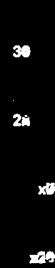

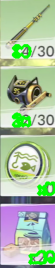

In [5]:
region = [[1412, 241], [1500, 670]]
diff = cv.absdiff(image1, image2)
# imshow(diff)
diff = np.max(diff, 2)
diff = diff[region[0][1]:region[1][1], region[0][0]:region[1][0]]
kernel = np.ones((3,3),np.uint8)
# diff = cv.morphologyEx(diff, cv.MORPH_OPEN, kernel)
# diff = cv.morphologyEx(diff, cv.MORPH_CLOSE, kernel)
diff = cv.GaussianBlur(diff, (3, 3), 0)
_, diff= cv.threshold(diff, 15, 255, cv.THRESH_BINARY)
imshow(diff)

contours, h = cv.findContours(diff, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
img = image1[region[0][1]:region[1][1], region[0][0]:region[1][0]].copy()
contours = [c for c in contours if cv.contourArea(c) > 10]
cv.drawContours(img, contours, -1, (0, 255, 0), 3)
# for i, c in enumerate(contours):
#   cv.drawContours(img, [c], -1, (0, 255 / (i+1), 2))
imshow(img)

In [6]:
len(contours)

4

[[ 33.067795 193.32204 ]
 [ 69.35443  412.3418  ]
 [ 73.28302  303.6415  ]
 [ 31.67347   83.591835]]


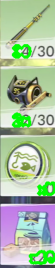

[(21, 74, 28, 19), (21, 183, 27, 20), (61, 293, 27, 19), (48, 402, 40, 20)]


In [7]:
points = []
for c in contours:
  if cv.contourArea(c) < 10:
    continue
  points.append(c)
points = np.float32(np.vstack(points))
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 100, 0.7)
ret, label, center = cv.kmeans(points, 4, None, criteria, 100,
                               cv.KMEANS_PP_CENTERS)
print(center)

img = image1[region[0][1]:region[1][1], region[0][0]:region[1][0]].copy()
region_boxes = []
for l, c in zip(range(4), center):
  contour = points[label.ravel()==l]
  contour = contour[np.linalg.norm(contour - c, axis=2) < 22]
  region_boxes.append(cv.boundingRect(contour))
  cv.drawContours(img, [np.intp(contour)], -1, (0, 255, 0), 3)
imshow(img)
raw_region_boxes = sorted(region_boxes, key=lambda b: b[1])
print(raw_region_boxes)

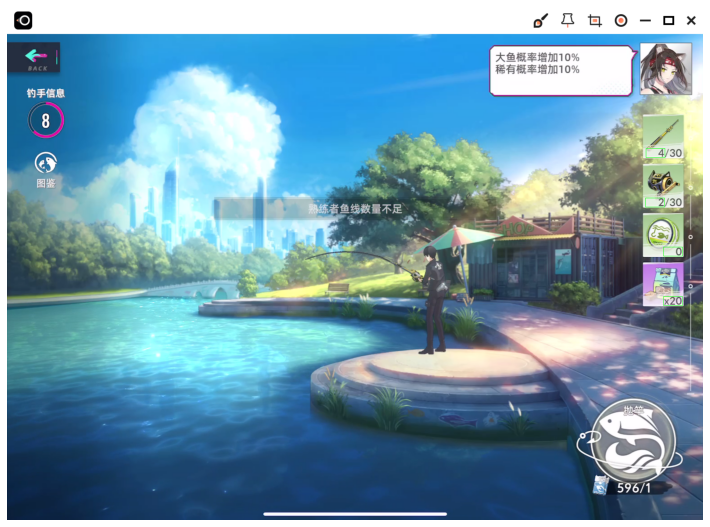

In [23]:
# manual normalize
w, h = 42, 20
region_boxes = np.array(raw_region_boxes)
region_boxes[:,0] += region[0][0]
region_boxes[:,1] += region[0][1]
for box in region_boxes:
  box[0] += box[2] - w
  box[1] += box[3] - h
  box[2] = w
  box[3] = h

img = image1.copy()
for x, y, w, h in region_boxes:
  cv.rectangle(img, (x, y), (x+w, y+h), (0, 255, 0), 1)
imshow(img)

In [24]:
%matplotlib inline
import pytesseract

frame = cv.imread('data/labeled/fish_idle/2022-08-11T09:50:58.408882.png')
crops = [frame[y:y+h, x:x+w] for x, y, w, h in region_boxes]
for img in crops:
  img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
  _, img = cv.threshold(img, 170, 255, cv.THRESH_BINARY)
  imshow(img)
  text = pytesseract.image_to_string(
      img,
      lang='snum',
      config="--psm 7 -c tessedit_char_whitelist=x0123456789")
  print(text)

30



28



x7



x15



In [25]:
import json

json.dump({
    'region_boxes': region_boxes.tolist(),
}, open('fish_idle_item_nums.json', 'w'))
